In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

# Script to look for antistie defects in experiment datasets
Test1: simulation results show that with image reconstructed from 0-4mrad, antisite column should show significantly higher intensity

## Dataset from STO substrate, as reference

In [54]:
RefPath = '/srv/home/chenyu/DEbackup/022119/C1/'
RefName = 'S0'
BeamLevel = 0
rx = 150
ry = 150
AccumulatedFrame = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / rx / ry
BeamLevel = BeamLevel / rx / ry
mask = np.heaviside(AccumulatedFrame-10,1)
MeanBeamLevel = (mask*AccumulatedFrame).sum()/np.count_nonzero(mask)
print(BeamLevel)
print(MeanBeamLevel)

14905786.219208037
164.82769077830847


1.1702152018052456


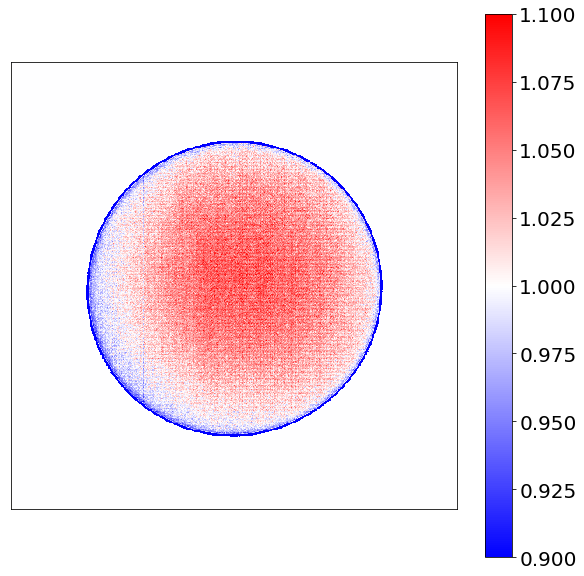

In [55]:
temp = (AccumulatedFrame + 13.93)/(1.38e7)
print((temp*mask).sum())
norm_mask = AccumulatedFrame/164*mask
norm_mask[norm_mask==0]=1
np.save('/srv/home/chenyu/DEbackup/022119/norm_mask.npy',norm_mask)
fig, ax = subplots(1,1,figsize=(10, 10))
im = ax.imshow(norm_mask,clim=[0.9,1.1],cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(im,ax=ax)
ax.set_xticks([])
ax.set_yticks([])
cbar.ax.tick_params(labelsize=20) 



In [56]:
np.save(path+'ZeroBeamMask.npy',mask)
np.save(path+'NormMask.npy',norm_mask)

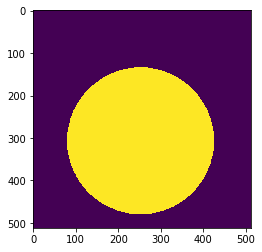

In [88]:
plt.imshow(CBFmask_outer)

In [90]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_OriginalPxSize/'
path = '/srv/home/chenyu/DEbackup/022119/'
name = 'S5/'
BeamLevel = np.load('/srv/home/chenyu/DEbackup/022119/BeamLevel.npy')
BlankCOM = np.load(path+'BlankCOM.npy')
mask = np.load(path+'ZeroBeamMask.npy')
norm_mask = np.load(path+'NormMask.npy')

# number of beam positions
rx = 150
ry = 150
# experiment diffraction pattern pixel size in mrad
exp_pxsize = 0.145
radius_inner = 25/exp_pxsize
radius_outer = 30/exp_pxsize

CBF = np.zeros((rx,ry))

for ix in range(rx):
    if ix % 10 == 0:
        print('Now working on row ' + str(ix))
    for iy in range(ry):
        ifile = ix*rx+iy+1
        frame = np.load(path + name + 'npy/S5_'+format(int(ifile),'05')+'.npy')
        frame = frame*mask/norm_mask + frame*(1-mask)
        CBFmask_inner = create_circular_mask(512,512,center=[BlankCOM[ix,iy,0],BlankCOM[ix,iy,1]],radius=radius_inner)
        CBFmask_outer = create_circular_mask(512,512,center=[BlankCOM[ix,iy,0],BlankCOM[ix,iy,1]],radius=radius_outer)
        CBFmask = CBFmask_outer & (~CBFmask_inner)
        CBF[ix,iy] = (frame*CBFmask/BeamLevel).sum()


Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


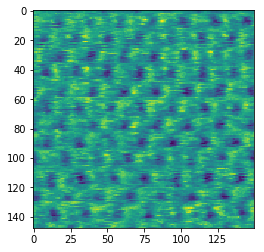

In [82]:
plt.imshow(CBF[1:-1,:])

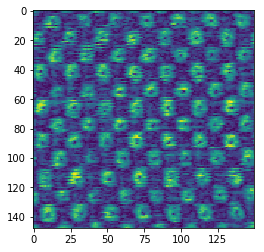

In [39]:
COM = np.load(path + name + 'COM.npy')
plt.imshow(np.sqrt(COM[1:-1,:,0]*COM[1:-1,:,0]+COM[1:-1,:,1]*COM[1:-1,:,1]))

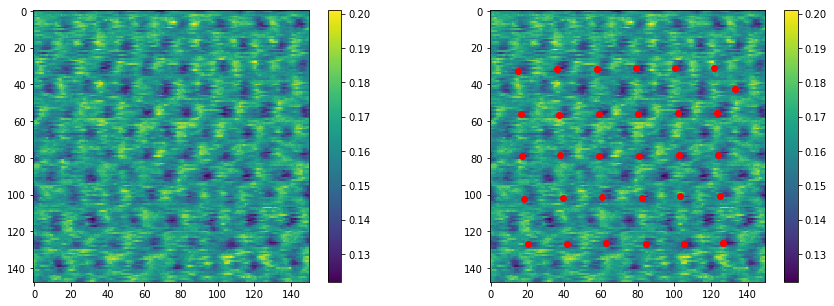

In [83]:
path = '/srv/home/chenyu/DEbackup/022119/'
name = 'S5/'

# CBF = np.load(path+name+'cBF-4.npy')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes.ravel()

im0 = ax[0].imshow(CBF[1:-1,:])
fig.colorbar(im0,ax=ax[0])

peaks_x = np.load(path + name + 'SrPeaks_x.npy')
peaks_y = np.load(path + name + 'SrPeaks_y.npy')

im1 = ax[1].imshow(CBF[1:-1,:])
ax[1].scatter(peaks_x+1,peaks_y,c='r')
fig.colorbar(im1,ax=ax[1])

# np.save(path+name+'cBF-4.npy',CBF)

In [84]:
# Integrate cBF-4 intensity for each peak
peaks_x = np.load(path + name + 'SrPeaks_x.npy')
peaks_y = np.load(path + name + 'SrPeaks_y.npy')
peaks_thickness = np.load(path + name + 'SrPeaks_thickness.npy')


peaks_cBF = np.zeros(peaks_x.shape[0])
for ipeak in range(peaks_cBF.shape[0]):
    mask = create_circular_mask(150,150, center=[peaks_x[ipeak],peaks_y[ipeak]], radius=8)
    peaks_cBF[ipeak] = np.sum(CBF*mask)/np.sum(mask)
    

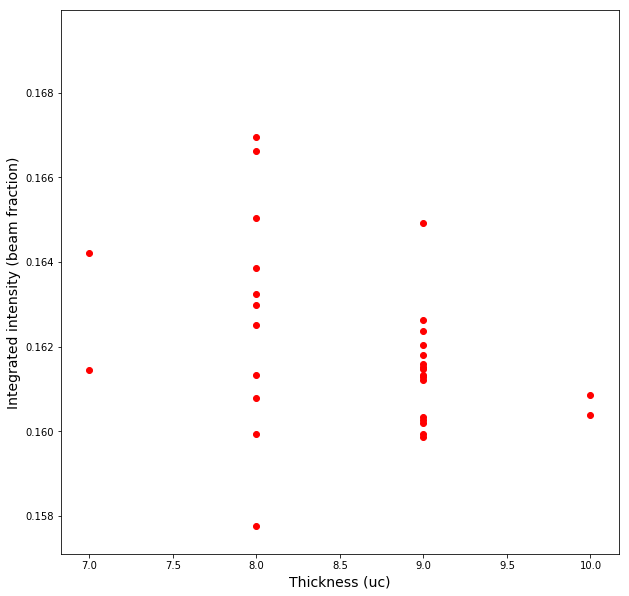

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.set_xlabel('Thickness (uc)',fontsize=14)
axes.set_ylabel('Integrated intensity (beam fraction)',fontsize=14)
for ipeak in range(peaks_cBF.shape[0]):
    if peaks_y[ipeak] > 0:
        axes.scatter(peaks_thickness[ipeak],peaks_cBF[ipeak],c='red')
np.save(path+name+'SrPeaks_cBF10.npy',peaks_cBF)

33.11258278145696
3442


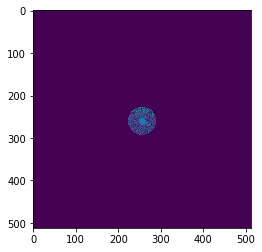

In [20]:
ix = 100
iy = 100
ifile = ix*rx+iy+1
frame = np.load(path + name + 'npy/S5_'+format(int(ifile),'05')+'.npy')
mask = create_circular_mask(512,512,center=[BlankCOM[ix,iy,0],BlankCOM[ix,iy,1]],radius=5/exp_pxsize)
CBF[ix,iy] = (frame*mask/BeamLevel).sum()
print(5/exp_pxsize)
print(mask.sum())
plt.imshow(frame*mask)
plt.scatter(BlankCOM[ix,iy,0],BlankCOM[ix,iy,1])

# Aux functions

In [6]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask